# Simulated data and linear cluster models

In [35]:
import matplotlib.pyplot as plt

In [36]:
from numpy.random import default_rng
rng = default_rng()

In [37]:
n = 100
split = 80

In [38]:
# Example where linear cluster models do not help
C = 2 * rng.random(n).reshape(-1, 1) - 1
X = 2 * rng.random(n).reshape(-1, 1) - 1
err = rng.normal(0, 0.1, n).reshape(-1, 1)
B = lambda C: 4

Y = X * B(C) + err

In [39]:
C_train, C_test = C[0:split], C[split:n]
X_train, X_test = X[0:split], X[split:n]
err_train, err_test = err[0:split], err[split:n]
Y_train, Y_test = Y[0:split], Y[split:n]

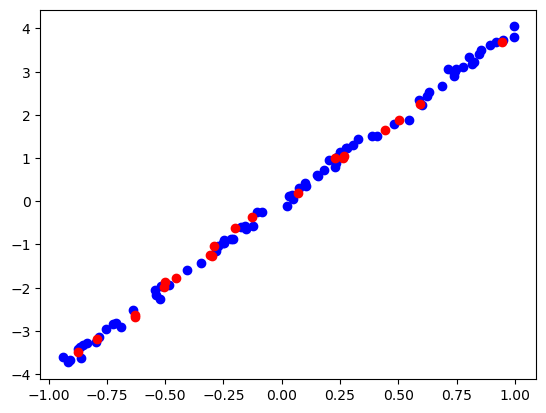

In [40]:
plt.scatter(X_train, Y_train, c='blue') # training set
plt.scatter(X_test, Y_test, c='red') # test set
plt.show()

In [41]:
from sklearn.cluster import KMeans

# Cluster by context: returns ndarray of same size as C, providing labels for clusters 0 thru k
def cluster_by_context(C, k):
    km = KMeans(n_clusters=k, init='random', 
            n_init=10, max_iter=300, 
            tol=0.001, random_state=0)
    km.fit(C)
    return km


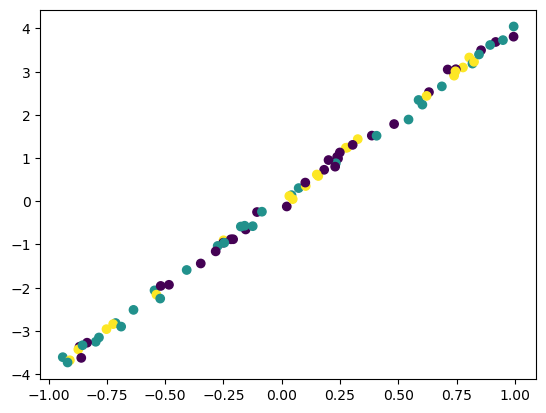

In [42]:
# Arbitrary choice of k=3
k = 3
clusterer = cluster_by_context(C_train, k)
clusters_train = clusterer.predict(C_train)
plt.scatter(X_train, Y_train, c=clusters_train)
plt.show()

In [43]:
from sklearn.linear_model import LinearRegression

# Generate linear regression model for each cluster
# Returns array of k models, one for each cluster
def linear_cluster_models(X, Y, k, clusters):
    models = []
    for i in range(k):
        filter_f = lambda x: x == i
        filter_arr = filter_f(clusters)
        X_i = X[filter_arr]
        Y_i = Y[filter_arr]
        reg = LinearRegression().fit(X_i, Y_i)
        models.append(reg)
    return models

In [44]:
# Train models
population_model = LinearRegression().fit(X_train, Y_train)
cluster_models = linear_cluster_models(X_train, Y_train, k, clusters_train)

In [49]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict from cluster model
def cluster_model_predict(cluster_models, clusterer, C_test, X_test, k):
    Y_pred = []
    predicted_clusters = clusterer.predict(C_test)
    print(predicted_clusters)
    for i in range(len(X_test)):
        cluster = predicted_clusters[i]
        model = cluster_models[cluster]
        Y_pred.append(model.predict(X_test[i].reshape(1, -1)))
    return np.array(Y_pred).reshape(-1, 1)

[0 2 0 0 0 1 0 1 2 0 1 2 0 2 2 0 1 2 0 2]


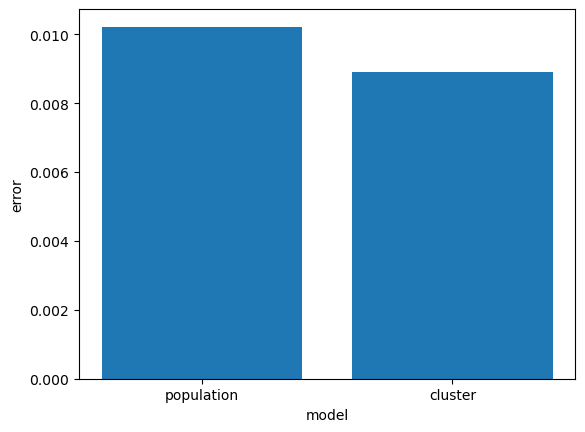

In [46]:
Y_pred_population = population_model.predict(X_test)
population_error = mean_squared_error(Y_pred_population, Y_test)

Y_pred_cluster = cluster_model_predict(cluster_models, clusterer, X_test, k)
cluster_error = mean_squared_error(Y_pred_cluster, Y_test)

fig, ax = plt.subplots()
ax.bar(['population', 'cluster'], [population_error, cluster_error])
ax.set_ylabel('error')
ax.set_xlabel('model')
plt.show()

The clustered model does slightly worse than the population model, likely due to overfitting.

## Examples where clustering is useful
### Example 1

[0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1]


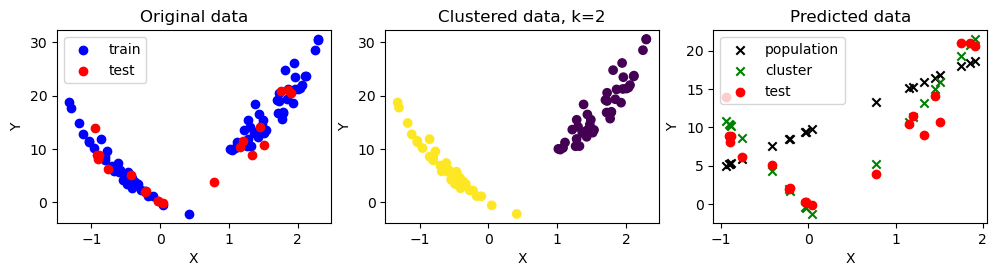

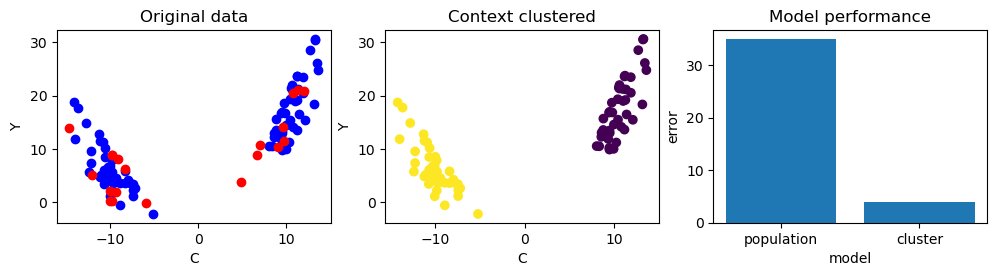

In [119]:
# Simulation
n = 100
split = (n // 5) * 4

Z1 = rng.normal(10, 2, n // 2).reshape(-1, 1)
Z2 = rng.normal(-10, 2, n // 2).reshape(-1, 1)

Z = np.concatenate((Z1, Z2))
rng.shuffle(Z)

C = Z
X = 0.1*Z + (rng.random(n)).reshape(-1, 1)
err = rng.normal(0, 0.1, n).reshape(-1, 1)
B = lambda C: C

Y = X * B(C) + err

C_train, C_test = C[0:split], C[split:n]
X_train, X_test = X[0:split], X[split:n]
Y_train, Y_test = Y[0:split], Y[split:n]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(12, 2.5)

ax1.set_title('Original data')
ax1.set_ylabel('Y')
ax1.set_xlabel('X')
sc1 = ax1.scatter(X_train, Y_train, c='blue') # training set
sc2 = ax1.scatter(X_test, Y_test, c='red') # test set
ax1.legend([sc1, sc2], ['train', 'test'])

# Cluster by context
k = 2
clusterer = cluster_by_context(C_train, k)
clusters_train = clusterer.predict(C_train)

ax2.set_title('Clustered data, k=' + str(k))
ax2.set_ylabel('Y')
ax2.set_xlabel('X')
ax2.scatter(X_train, Y_train, c=clusters_train)

# Train models
population_model = LinearRegression().fit(X_train, Y_train)
cluster_models = linear_cluster_models(X_train, Y_train, k, clusters_train)

# Evaluate models
Y_pred_population = population_model.predict(X_test)
population_error = mean_squared_error(Y_test, Y_pred_population)

Y_pred_cluster = cluster_model_predict(cluster_models, clusterer, C_test, X_test, k)
cluster_error = mean_squared_error(Y_test, Y_pred_cluster)

ax3.set_title('Predicted data')
ax3.set_ylabel('Y')
ax3.set_xlabel('X')
pred1 = ax3.scatter(X_test, Y_pred_population, c='black', marker='x')
pred2 = ax3.scatter(X_test, Y_pred_cluster, c='green', marker='x')
truth = ax3.scatter(X_test, Y_test, c='red')
ax3.legend([pred1, pred2, truth], ['population', 'cluster', 'test'])

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 2.5)

axs[0].set_title('Original data')
axs[0].set_ylabel('Y')
axs[0].set_xlabel('C')
scblue = axs[0].scatter(C_train, Y_train, c='blue') # training set
scred = axs[0].scatter(C_test, Y_test, c='red') # test set
ax1.legend([scblue, scred], ['train', 'test'])

axs[1].set_title('Context clustered')
axs[1].set_ylabel('Y')
axs[1].set_xlabel('C')
axs[1].scatter(C_train, Y_train, c=clusters_train)

axs[2].bar(['population', 'cluster'], [population_error, cluster_error])
axs[2].set_title('Model performance')
axs[2].set_ylabel('error')
axs[2].set_xlabel('model')

plt.show()

In this case, we had a linear B(C) and clearly defined clusters for C. The cluster model greatly outperformed the population model.

### Example 2

[0 4 4 4 1 0 2 3 1 3 2 4 4 3 4 1 0 0 4 1]


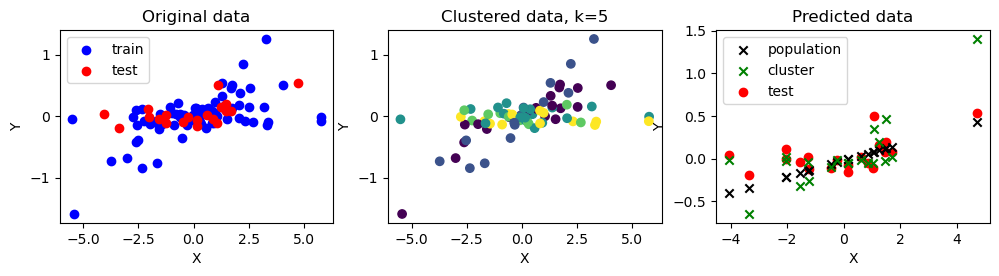

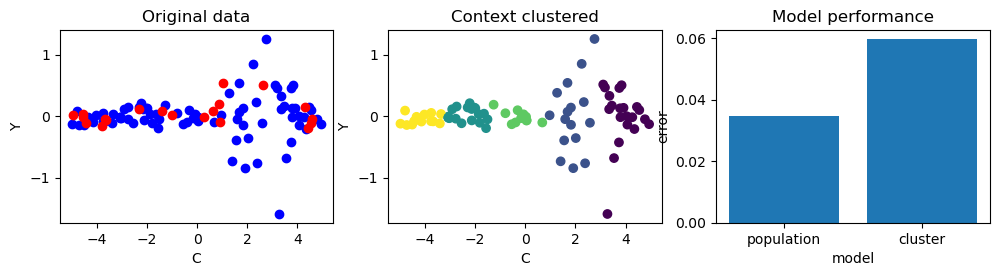

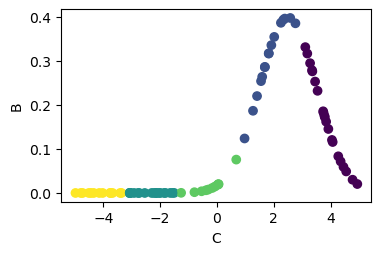

In [150]:
# Simulation
n = 100
split = (n // 5) * 4

C = (10 * rng.random(n) - 5).reshape(-1, 1)
X = rng.normal(0, 2, n).reshape(-1, 1)
err = rng.normal(0, 0.1, n).reshape(-1, 1)

mu = 5
sigma = 2
B = lambda C: 2 * (1 / np.sqrt(2 * np.pi * np.square(sigma)) * np.exp(-1/2 * np.square(C - mu / sigma)))

Y = X * B(C) + err

C_train, C_test = C[0:split], C[split:n]
X_train, X_test = X[0:split], X[split:n]
Y_train, Y_test = Y[0:split], Y[split:n]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(12, 2.5)

ax1.set_title('Original data')
ax1.set_ylabel('Y')
ax1.set_xlabel('X')
sc1 = ax1.scatter(X_train, Y_train, c='blue') # training set
sc2 = ax1.scatter(X_test, Y_test, c='red') # test set
ax1.legend([sc1, sc2], ['train', 'test'])

# Cluster by context
k = 5
clusterer = cluster_by_context(C_train, k)
clusters_train = clusterer.predict(C_train)

ax2.set_title('Clustered data, k=' + str(k))
ax2.set_ylabel('Y')
ax2.set_xlabel('X')
ax2.scatter(X_train, Y_train, c=clusters_train)

# Train models
population_model = LinearRegression().fit(X_train, Y_train)
cluster_models = linear_cluster_models(X_train, Y_train, k, clusters_train)

# Evaluate models
Y_pred_population = population_model.predict(X_test)
population_error = mean_squared_error(Y_test, Y_pred_population)

Y_pred_cluster = cluster_model_predict(cluster_models, clusterer, C_test, X_test, k)
cluster_error = mean_squared_error(Y_test, Y_pred_cluster)

ax3.set_title('Predicted data')
ax3.set_ylabel('Y')
ax3.set_xlabel('X')
truth = ax3.scatter(X_test, Y_test, c='red')
pred1 = ax3.scatter(X_test, Y_pred_population, c='black', marker='x')
pred2 = ax3.scatter(X_test, Y_pred_cluster, c='green', marker='x')
ax3.legend([pred1, pred2, truth], ['population', 'cluster', 'test'])

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 2.5)

axs[0].set_title('Original data')
axs[0].set_ylabel('Y')
axs[0].set_xlabel('C')
scblue = axs[0].scatter(C_train, Y_train, c='blue') # training set
scred = axs[0].scatter(C_test, Y_test, c='red') # test set
ax1.legend([scblue, scred], ['train', 'test'])

axs[1].set_title('Context clustered')
axs[1].set_ylabel('Y')
axs[1].set_xlabel('C')
axs[1].scatter(C_train, Y_train, c=clusters_train)

axs[2].bar(['population', 'cluster'], [population_error, cluster_error])
axs[2].set_title('Model performance')
axs[2].set_ylabel('error')
axs[2].set_xlabel('model')

fig, ax = plt.subplots()
fig.set_size_inches(4, 2.5)
ax.set_ylabel('B')
ax.set_xlabel('C')
ax.scatter(C_train, B(C_train), c=clusters_train)

plt.show()

# Thoughts on exercise

Situations where a cluster model does well:
- C has a large impact on Y.
    - In Example 1, where B(C) is linear, increasing its slope makes the cluster model perform even better relative to the population model.
    - In Example 2, multiplying B(C) by a constant > 1 again made the cluster model perform better. I tried shifting the range of B(C), which didn't have that much effect.
    - The cluster model didn't do well on the original "bad" example because Y was independent of C, so C didn't provide any useful information for predicting Y.
- There isn't too much noise. When there is a lot of noise, both models perform poorly, and the cluster model doesn't do much better than the population model.

What if:
- C and X are dependent? I tried drawing both C and X from an underlying distribution Z; whether this was good or bad for the cluster model depended on the parameters. I'm not sure exactly what the effect of a dependence relationship is.
- Data is high-dimensional? I didn't try this, but my guess would be that it would decrease the performance of cluster models because distance metrics aren't as meaningful in high-dimensional space; also, the data would be more sparse. (Curse of dimensionality)